# Pizza Sales Analysis

This project is based on a challenge from Maven Analytics, where the data was given, and the image above contains a little explanation and some questions about the data. The data is about sales from a fictional pizza place during a year.

![image](image.png)

## The Data

The data given, is divided in four soucers:

### Order information

- 'order_id' - The ID of the order (matches the order_details data)
- 'date' - the date of the order
- 'time' the time of the order

### Order Details information

- 'order_details_id' - The ID for the order detail
- 'order_id' - The ID of the order refered to (matches the order data)
- 'pizza_id' - The ID of the pizza for the order (matches the pizza data)
- 'quantity' -  The number of pizzas mentioned on 'pizza_id' for that order

### Pizza information

- 'pizza_id' - The ID of the pizza  (matches ..)
- 'pizza_type_id' - The ID for the type of the pizza (matches witch the pizza_type data)
- 'size' - The size of the Pizza ('S','M','L','XL','XXL')
- 'price' - The price of the Pizza

### Pizza Types Information

- 'pizza_type_id' - The ID for the type of the pizza (matches witch the pizza data)
- 'name' - The name for this pizza type
- 'category' - Category for the pizza type (e.g. Chicken, Veggie, Meat, etc)
- 'ingredients' - A list of the ingredients of this pizza type

In [1]:
# importing the modules that will be needed in the code
import seaborn as sns
import pingouin as png
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm

In [2]:
# reading our data, i'm already formating the date type for the order data
order = pd.read_csv('orders.csv',parse_dates=['date','time'])
order.time = order.time.dt.strftime('%H:%M')
pizzas = pd.read_csv('pizzas.csv')
pizza_types = pd.read_csv('pizza_types.csv',encoding='latin1')
order_details = pd.read_csv('order_details.csv')

In [3]:
order_details.pizza_id = order_details.pizza_id.astype('string')
pizzas.pizza_id = pizzas.pizza_id.astype('string')

Before answering the questions I'll take a first look at the data

In [4]:
pizza_types.head()

pizza_type_id  ...                                        ingredients
0       bbq_ckn  ...  Barbecued Chicken, Red Peppers, Green Peppers,...
1      cali_ckn  ...  Chicken, Artichoke, Spinach, Garlic, Jalapeno ...
2   ckn_alfredo  ...  Chicken, Red Onions, Red Peppers, Mushrooms, A...
3     ckn_pesto  ...  Chicken, Tomatoes, Red Peppers, Spinach, Garli...
4    southw_ckn  ...  Chicken, Tomatoes, Red Peppers, Red Onions, Ja...

[5 rows x 4 columns]

In [5]:
order.info()
pizzas.info()
pizza_types.info()
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21350 entries, 0 to 21349
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   order_id  21350 non-null  int64         
 1   date      21350 non-null  datetime64[ns]
 2   time      21350 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 500.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pizza_id       96 non-null     string 
 1   pizza_type_id  96 non-null     object 
 2   size           96 non-null     object 
 3   price          96 non-null     float64
dtypes: float64(1), object(2), string(1)
memory usage: 3.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------      

In [6]:
order.describe()

order_id
count  21350.000000
mean   10675.500000
std     6163.358459
min        1.000000
25%     5338.250000
50%    10675.500000
75%    16012.750000
max    21350.000000

In [7]:
pizzas.describe()

price
count  96.000000
mean   16.440625
std     4.090266
min     9.750000
25%    12.500000
50%    16.250000
75%    20.250000
max    35.950000

In [8]:
pizza_types.describe()

pizza_type_id  ...                                        ingredients
count             32  ...                                                 32
unique            32  ...                                                 32
top          bbq_ckn  ...  Barbecued Chicken, Red Peppers, Green Peppers,...
freq               1  ...                                                  1

[4 rows x 4 columns]

In [9]:
order_details.describe()

order_details_id      order_id      quantity
count      48620.000000  48620.000000  48620.000000
mean       24310.500000  10701.479761      1.019622
std        14035.529381   6180.119770      0.143077
min            1.000000      1.000000      1.000000
25%        12155.750000   5337.000000      1.000000
50%        24310.500000  10682.500000      1.000000
75%        36465.250000  16100.000000      1.000000
max        48620.000000  21350.000000      4.000000

## 1. How many customers do we have each day? Are there any peak hours?

Since there's no registration of customers of any type, I'll consider the orders to answer this question. So I'll only use the order data which already contains the order id and date and time.

In [10]:
# to get the number of order per day i'll divide the total count of order by the number of unique days we have in the data 
# and round it!
order_per_day = len(order.order_id)/len(order.date.unique())
print('Number of orders per day : ',round(order_per_day,0))

Number of orders per day :  60.0


The pizza place had a mean of 60 orders a day during 2015

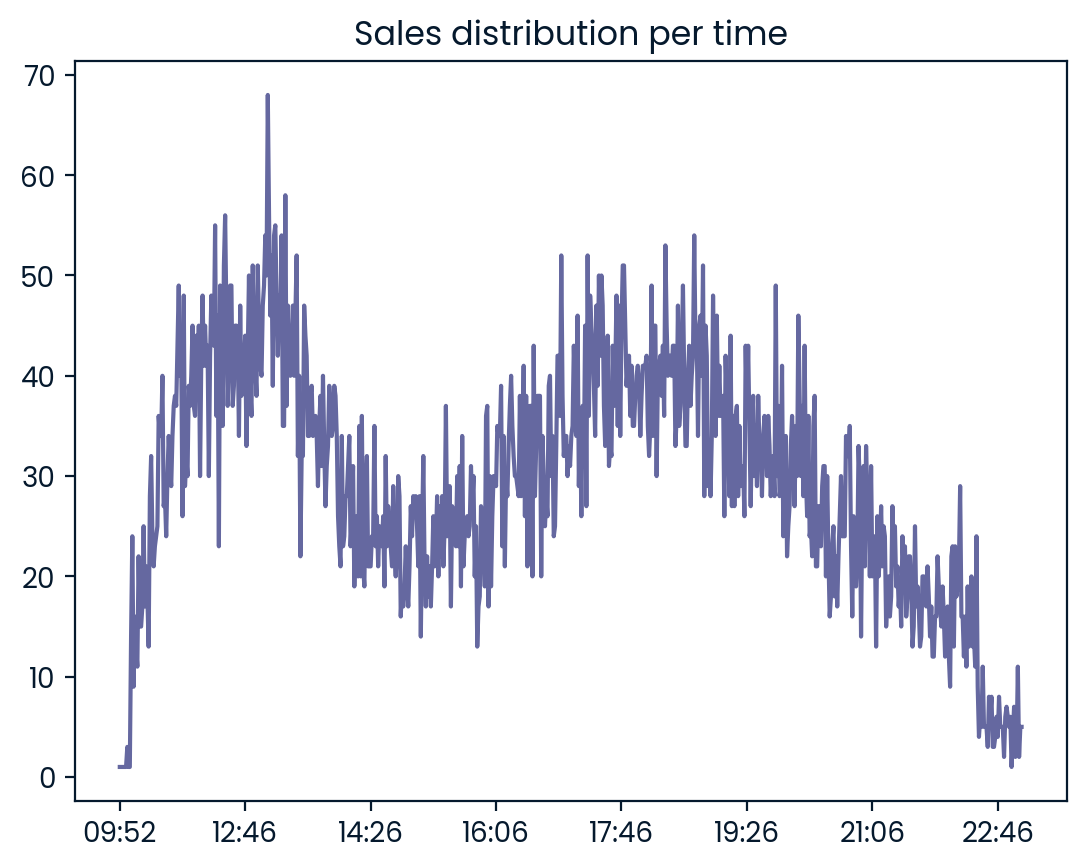

In [11]:
#plotting the sales by time
order.time.sort_values().value_counts(sort=False).plot()
plt.title('Sales distribution per time')
plt.show()

## 2. How many pizzas are tipically in an order? Do we have any bestsellers?

In [12]:
pizza_mean = round(order_details.quantity.sum()/len(order),0)
print('The mean number of pizzas per order : ',pizza_mean)

The mean number of pizzas per order :  2.0


In [13]:
# joining the order details and the pizza df's to get more data about the orders
ordered_pizzas = order_details.merge(pizzas, on='pizza_id')
ordered_pizzas['total_price'] = ordered_pizzas.quantity * ordered_pizzas.price

In [14]:
# using the merged data to gete the best seller by quantity
best_seller_type_id = ordered_pizzas.groupby('pizza_type_id')['quantity'].sum().sort_values(ascending=False).index[0]
best_seller = pizza_types[pizza_types['pizza_type_id']==best_seller_type_id]['name'].iloc[0]
print('The best seller pizza is ',best_seller)

The best seller pizza is  The Classic Deluxe Pizza


The mean number of pizzas per order is 2, and the best seller is The Classic Deluxe Pizza

## 3. How much money did we make this year? Can we identify any seasonality in sales?

In [15]:
revenue2015 = ordered_pizzas['total_price'].sum()
print('The total money made in 2015 with the pizzas was ',round(revenue2015,2))

The total money made in 2015 with the pizzas was  817860.05


The total amount of money made with the pizza sales was $817860,05 in the year 2015

<AxesSubplot: xlabel='date'>

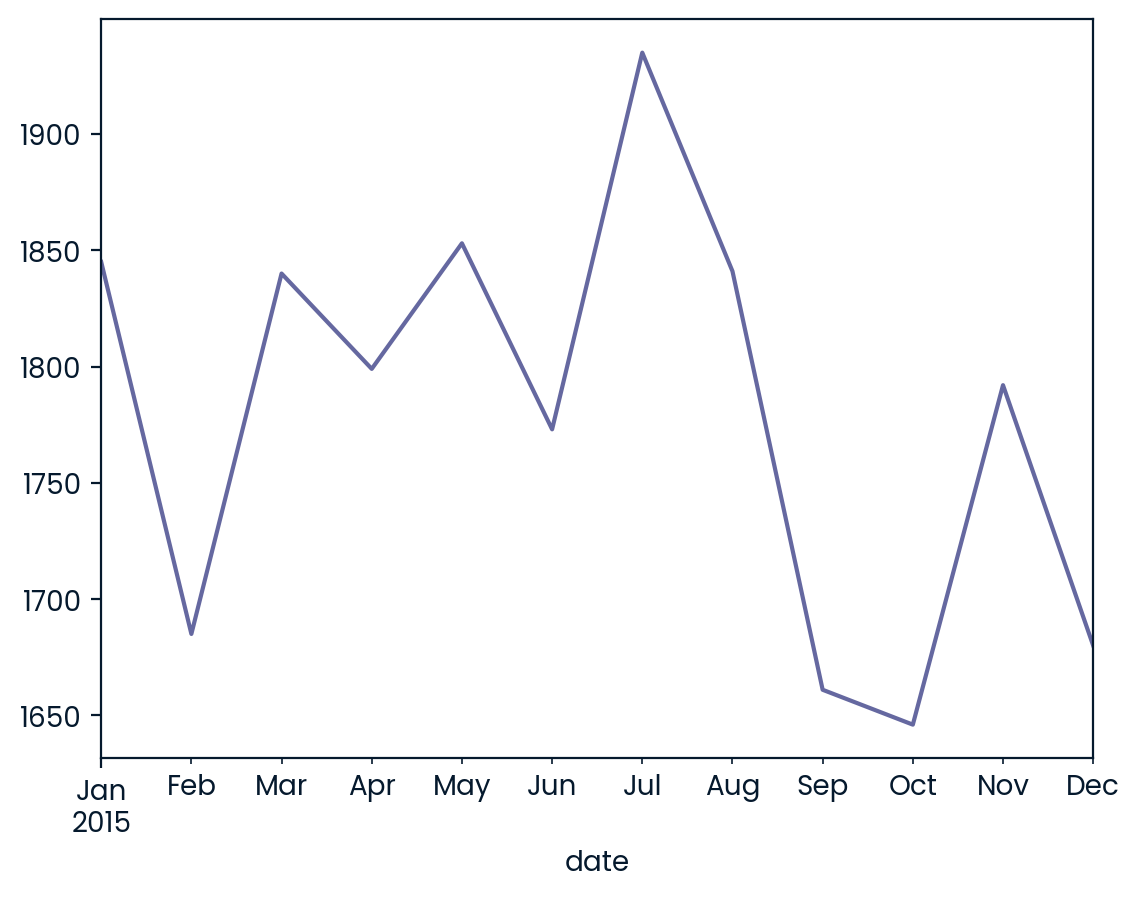

In [16]:
# to make the visualization clear i resampled the date monthly
order.resample('M',on='date')['order_id'].count().plot()

We have a raise by the end of June going to its peak in July, but then falling drastically to September and October. The sales in February were also way less comparing to the rest

## 4. Are there any pizzas we should take of the menu, or any promotions we could leverage?

As showed below there's almost a group division around each 500's sales. And the only one that stands under 500 sales is brie carre, which also have a much higher mean price than the rest.

In [17]:
# Group the data by pizza_type and calculate the count and mean price
pizza_type_counts = ordered_pizzas.groupby('pizza_type_id').agg(count=('pizza_type_id', 'count'), mean_price=('price', 'mean')).reset_index()

# Sort the dataframe by count in descending order
pizza_type_counts = pizza_type_counts.sort_values('count', ascending=True)

# Create the vertical bar plot using plotly
fig = px.bar(pizza_type_counts, y='pizza_type_id', x='count', color='mean_price', title='Pizza Sold per Pizza Type', labels={'pizza_type_id': 'Pizza Type', 'count': 'Quantity Sold', 'mean_price': 'Mean Price'}, color_continuous_scale='inferno_r', orientation='h',height=650)

# Update the color of the grid lines and increase the grid size
fig.update_xaxes(showgrid=True, gridcolor='rgba(0, 0, 0, 0.4)', gridwidth=1.5)
fig.update_yaxes(showgrid=True, gridcolor='rgba(0, 0, 0, 0.2)', gridwidth=1.5)

fig.show()

In [18]:
# check the sizes for brie carre pizza
pizzas[pizzas['pizza_type_id']=='brie_carre']['size'].value_counts()

S    1
Name: size, dtype: int64

In [19]:
#mean price per size
pizzas.groupby('size')['price'].mean()

size
L      20.022581
M      15.991935
S      12.512500
XL     25.500000
XXL    35.950000
Name: price, dtype: float64

In [20]:
# Checking if the price has influence in the amount of pizzas sold

# Select the relevant columns from the ordered_pizzas dataframe
data = ordered_pizzas[['price', 'quantity']]

# Group the data by price and calculate the sum of quantity for each price
grouped_data = data.groupby('price')['quantity'].sum().reset_index()

# Define the dependent variable (y) and independent variable (X)
y = grouped_data['quantity']
X = grouped_data['price']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.1804
Date:                Fri, 21 Jun 2024   Prob (F-statistic):              0.675
Time:                        13:29:22   Log-Likelihood:                -226.75
No. Observations:                  25   AIC:                             457.5
Df Residuals:                      23   BIC:                             459.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2550.9552   1407.332      1.813      0.083    -360.334    5462.244
price        -33.3683     78.562     -0.425      0.675    -195.885     129.149
==============================================================================
Omnibus:                       17.546   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.463
Skew:                           1.702   Prob(JB):                     5.94e-05
Kurtosis:                       5.665   Cond. No.                         57.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The brie carre pizza has only the size 'S', and even though the linear regression model found a r-square of only 0.008 for the price explaining the sales, the mean price for pizzas with size 'S' (Small) is 12.5, and the brie carre small pizza is 23.65, almost twice the mean price, which it's also more expensive than the mean of large pizzas.

Text(0.5, 1.0, 'Unique pizza types per size')

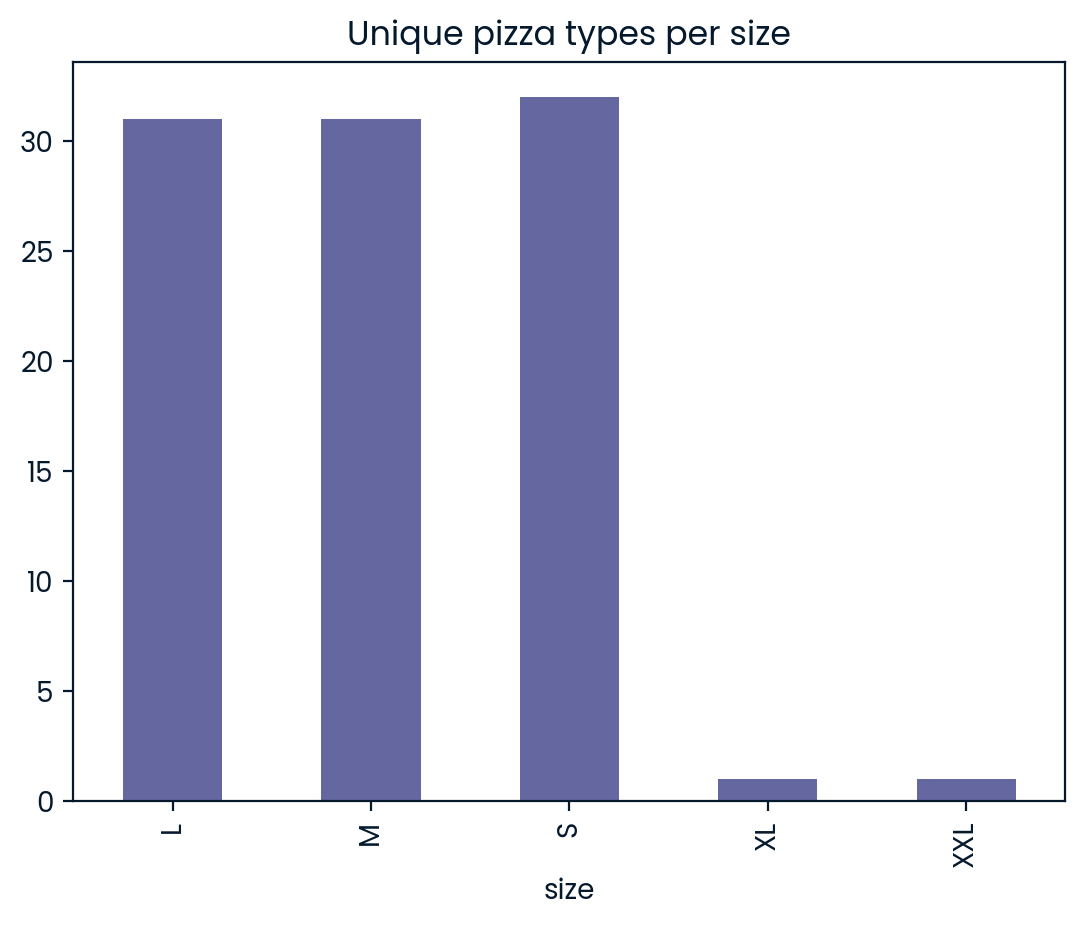

In [21]:
# check the number of pizza type per size
sizes = pizzas.groupby('size')['pizza_type_id'].nunique()
sizes.plot(kind='bar')
plt.title('Unique pizza types per size')

In [22]:
# number of sizes per pizza type
sizes_per_type = pizzas.groupby('pizza_type_id')['size'].count()
sizes_per_type

pizza_type_id
bbq_ckn         3
big_meat        3
brie_carre      1
calabrese       3
cali_ckn        3
ckn_alfredo     3
ckn_pesto       3
classic_dlx     3
five_cheese     3
four_cheese     3
green_garden    3
hawaiian        3
ital_cpcllo     3
ital_supr       3
ital_veggie     3
mediterraneo    3
mexicana        3
napolitana      3
pep_msh_pep     3
pepperoni       3
peppr_salami    3
prsc_argla      3
sicilian        3
soppressata     3
southw_ckn      3
spicy_ital      3
spin_pesto      3
spinach_fet     3
spinach_supr    3
thai_ckn        3
the_greek       5
veggie_veg      3
Name: size, dtype: int64

In [23]:
# check for pizzas with size XL and XXL
xlxxl = pizzas[(pizzas['size']=='XL') | (pizzas['size']=='XXL')]
xlxxl

pizza_id pizza_type_id size  price
42   the_greek_xl     the_greek   XL  25.50
43  the_greek_xxl     the_greek  XXL  35.95

The Brie carre is the only type of pizza that has only one size and the greek is the only one that have XL an XXL sizes

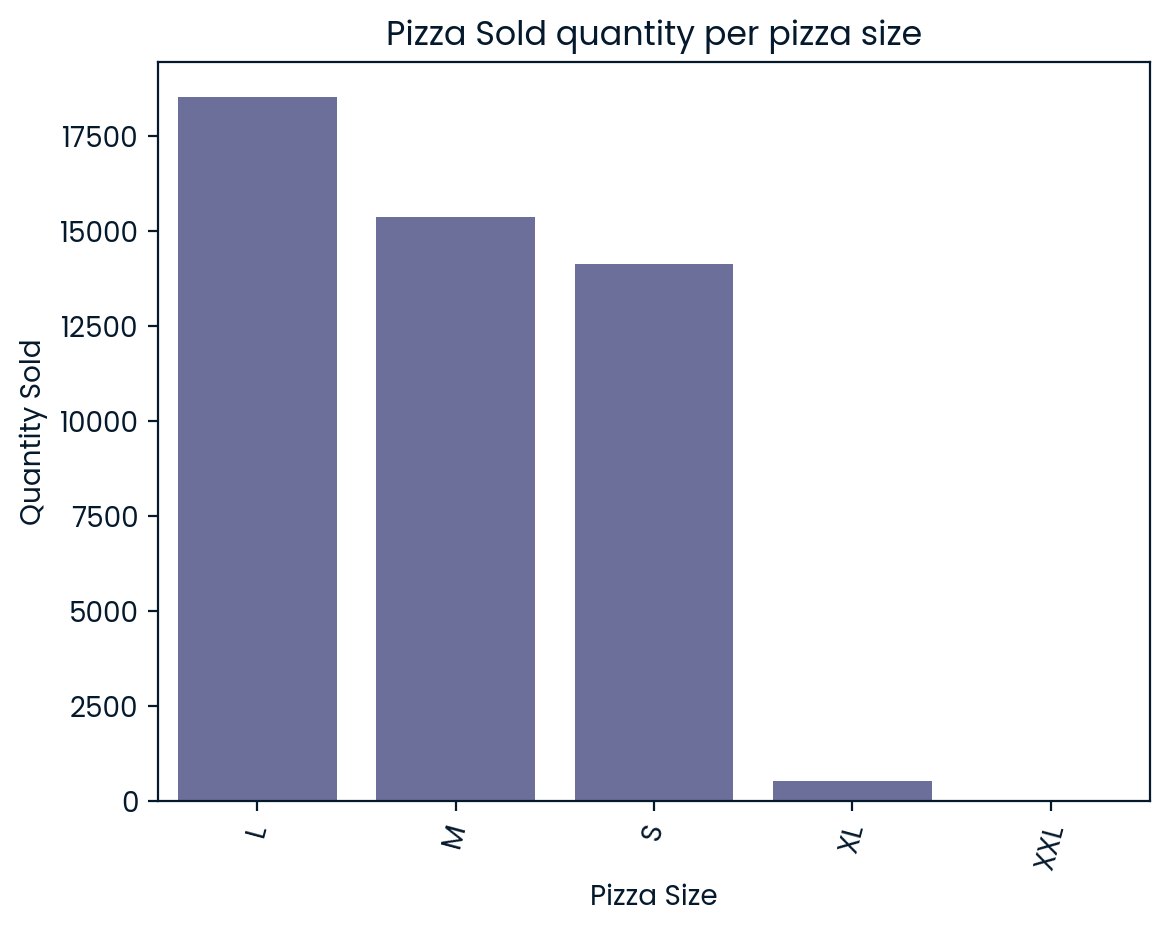

In [24]:
#plot the pízzas sales per pizza size
data = ordered_pizzas.groupby("size").size().reset_index(name='count')  

sns.barplot(x='size',y='count', data=data)

plt.title('Pizza Sold quantity per pizza size')
plt.ylabel('Quantity Sold')
plt.xlabel('Pizza Size')
plt.xticks(rotation=75)
plt.show()

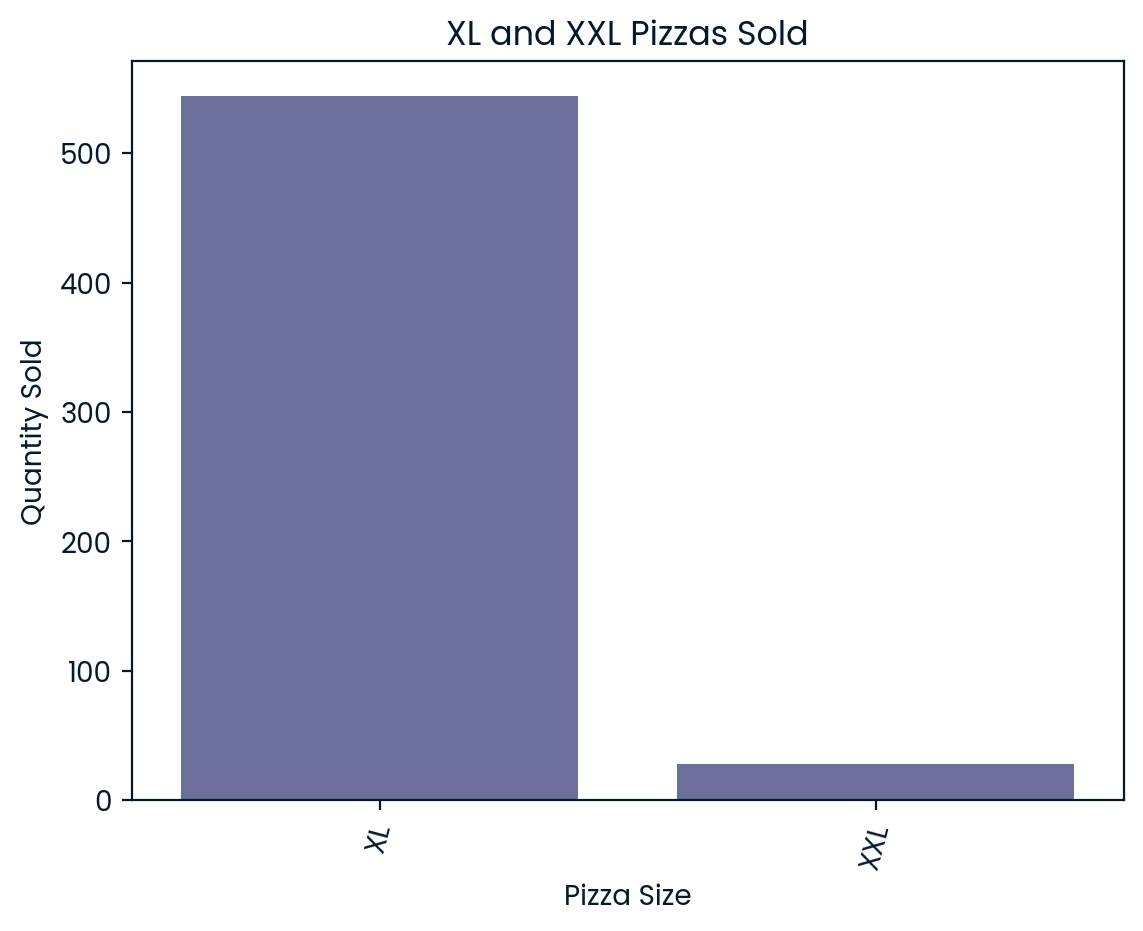

In [25]:
#plot the pizza sales for pizzas size XL and XXL

data = ordered_pizzas[(ordered_pizzas['size']=='XL') | (ordered_pizzas['size']=='XXL')].groupby("size").size().reset_index(name='count')  

sns.barplot(x='size',y='count', data=data)

plt.title('XL and XXL Pizzas Sold')
plt.ylabel('Quantity Sold')
plt.xlabel('Pizza Size')
plt.xticks(rotation=75)
plt.show()

The XXL size pizzas (The Greek) sold less than 50 units.

In [26]:
# create a list for all the ingredients used for all pizzas and clear duplicates
ing_list = [x.strip() for i in range(pizza_types['ingredients'].size) for x in pizza_types['ingredients'].tolist()[i].split(',')]
ing_list = list( dict.fromkeys(ing_list) )
ing_list.sort()

In [27]:
# Create a dataframe with the ingredients as column and pizza names as rows 
# and store if the pizzas have that ingredient or not

pizza_ing = pd.DataFrame()

# Add the pizza names as rows for 'pizza'
pizza_ing['pizza'] = pizza_types['name']

# Add one collumn for ingredient from ing_list
for ing in ing_list:
    pizza_ing[ing] = 2

# Filling the df with 1 if the ingredient is part of that pizza or 0 if not
for pizzas in pizza_types.iterrows(): 
    for ingredient in ing_list:
        if any([x.strip()==ingredient for x in pizzas[1][3].split(',')]):
            pizza_ing[ingredient][pizza_ing['pizza']==pizzas[1][1]] = 1
        else:
            pizza_ing[ingredient][pizza_ing['pizza']==pizzas[1][1]] = 0

pizza_ing['num_ing'] = pizza_ing.sum(axis=1)

In [28]:
# plot a treemap to the number of ingredient for each pizza type

fig = px.treemap(pizza_ing, path=[px.Constant("all"), 'pizza'], values='num_ing',labels={'num_ing': 'Ingredients Count'}, color='num_ing',color_continuous_scale='inferno_r')
fig.update_layout(title='Number of Ingredients per Pizza')

The best seller pizza (The Classic Deluxe) has 5 ingredients while the worst seller has 6, so the number of ingredients is not the best way to explain the sales either

In [29]:
# Create an empty dataframe
ing_df = pd.DataFrame()
# Add the values of ing_list as a column
ing_df['ingredients'] = ing_list
# Add one collumn for each pizza name
for pizzas in pizza_types.iterrows():
    ing_df[pizzas[1][1]] = 0
# Filling the df with 1 if the ingredient is part of that pizza e.g. df[the barbecue chicken pizza][Tomatoes] = 1
for ingredient in ing_list:
    for pizzas in pizza_types.iterrows():
        if any([x.strip()==ingredient for x in pizzas[1][3].split(',')]):
            ing_df[pizzas[1][1]][ing_df['ingredients']==ingredient] = 1
        else:
            ing_df[pizzas[1][1]][ing_df['ingredients']==ingredient] = 0
            
ing_df['ing_appear'] = ing_df.sum(axis=1)

In [30]:
pizza_types[pizza_types['name'] == 'The Classic Deluxe Pizza']

pizza_type_id  ...                                        ingredients
7   classic_dlx  ...  Pepperoni, Mushrooms, Red Onions, Red Peppers,...

[1 rows x 4 columns]

For promotions, one way to go is the best sellers (more than 2000 units sold), to try make it even more of those ones. The brie carre could also be put in promotion to see if the price is the reason for not selling good, even though the price is not the main criteria for the sales, but in this case we have a limited size categories, and a price much higher than the mean for small pizzas. If this type of pizza really need to be that much more expensive than the rest, the recomendation is to see if it will sell more if different sizes are offered, if not it could be taken off the menu. The "XXL Greek Pizza" has sold less than 50 units so is one option to be taken off the menu too. 

## Conclusion

This pizza Place has a mean of 60 orders a day with a mean of 2 pizzas per order. 
The best seller is 'the classic deluxe'. The total revenue for 2015 was $ 817.860,05. 
There was a big raise in sales in august, but in february september and october the sales were way less. 

There is five sizes of pizza, but two of them are only offered by one pizza, Xl and XXL. It could be patterned by either making those sizes for the rest of the pizzas or taking them out of the menu, mainly the XXL, that sold less than 50 units. 

The brie carre pizza it's the worst seller, but it has two peculiarities, it's only offered in one size, and has a much higher price than the mean to this size. It could be offered in different size, and should be done a review to it's price.A promotion could be a good ideia to see if it will sell more, there could also have a promotion on the top sellers too since the clients seem to like those. 

For further analysis, it could be a research on what combination of products work better, and try to enhance the menu with this info, adding new pizza types and removing the ones that don't work that well

Please fell free to let any comments and suggestion, and if you wanna contact me you can reach me via [Linkedin](https://www.linkedin.com/in/caio-gonzaga-alves/). If you wanna see more there's also my [Portfolio](https://www.caioalves.com/) and [Github](https://github.com/Caio-G) page.